In [1]:
import numpy
import pickle
from modules.support_functions import Utils
from matplotlib import pyplot as plt
from modules.Modularity import RecursiveModularity
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
num_workers = 4
import pandas as pd
from catboost import CatBoostRegressor
import shap
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode()

In [2]:
from littleballoffur import DegreeBasedSampler, \
    PageRankBasedSampler, \
    RandomEdgeSampler, \
    SnowBallSampler, \
    ForestFireSampler, \
    CommunityStructureExpansionSampler, \
    ShortestPathSampler, \
    RandomWalkSampler, \
    RandomWalkWithJumpSampler, \
    MetropolisHastingsRandomWalkSampler, \
    NonBackTrackingRandomWalkSampler, \
    CirculatedNeighborsRandomWalkSampler, \
    CommonNeighborAwareRandomWalkSampler, \
    LoopErasedRandomWalkSampler

methods = [
    # random node sampling
    DegreeBasedSampler,
    PageRankBasedSampler,

    # Random Edge Sampling
    RandomEdgeSampler,
    SnowBallSampler,
    CommunityStructureExpansionSampler,
    ShortestPathSampler,
    # Random-Walks Dased
    RandomWalkSampler,
    RandomWalkWithJumpSampler,
    MetropolisHastingsRandomWalkSampler,
    NonBackTrackingRandomWalkSampler,
    #RecursiveModularity
]

**загрузка данных**

In [3]:
with open('all_graphs.pickle','rb') as f:
    graphs = pickle.load(f)

#Загрузка распределения мотивов для полных графов
X_full_f1 = numpy.load('DataHelp/motifs_matrix_full_f1.npy')
X_full_f3 = numpy.load('DataHelp/motifs_matrix_full_f3.npy')
#X_full_nodif = numpy.load('DataHelp/motifs_matrix_full.npy')

#Загрузка словарей распределения мотивов для сэмплов. 

with open('./DataHelp/motifs_samples_forMSE.pickle', 'rb') as f:
        X_sample=pickle.load(f)
with open('./DataHelp/motifs_samples_f1_forMSE.pickle', 'rb') as f:
        X_sample_f1=pickle.load(f)
with open('./DataHelp/motifs_samples_f3_forMSE.pickle', 'rb') as f:
        X_sample_f3=pickle.load(f)
#Каждый подграф кроме Modularity повторен 10 раз из-за стохастических методов. 
#Поэтому для одного экзмепляра надо взять первые 170 строчек (или вторые 170 стр и тд)

X_sample_regression = dict(map(lambda e: (e[0], dict(map(lambda o: (o[0],o[1][:len(graphs)]),e[1].items()))),X_sample.items()))
X_sample_f3_regression = dict(map(lambda e: (e[0], dict(map(lambda o: (o[0], o[1][:len(graphs)]), e[1].items()))), X_sample_f3.items()))
X_sample_f1_regression = dict(map(lambda e: (e[0], dict(map(lambda o: (o[0], o[1][:len(graphs)]), e[1].items()))), X_sample_f1.items()))

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def find_MSE(X_f1, X_f3, X_samples_f1, X_samples_f3,
             graphs, inp):  #возвращает MSE для мотивов f1 И f3. Без разделения на разные типы мотивов. Размеры мотивов 3 и 4
    method, number_of_nodes = inp
    MSE_f1 = []
    MSE_f3 = []
    MSE_nodif = []

    for i, graph in enumerate(graphs):
        if number_of_nodes <= graph[1].number_of_nodes():
            motifs = X_f1[i]
            motifs_disjoint = X_f3[i]
            motifs_sample_con = X_samples_f1['Number of nodes: ' + str(number_of_nodes)][i]
            motifs_disjoint_sample_con = X_samples_f3['Number of nodes: ' + str(number_of_nodes)][i]
           
            MSE_f1.append(mean_squared_error(motifs, motifs_sample_con))
            MSE_f3.append(mean_squared_error(motifs_disjoint, motifs_disjoint_sample_con))
            
        else:
            MSE_f1.append(0)
            MSE_f3.append(0)
          
    return number_of_nodes, MSE_f1, MSE_f3, MSE_nodif


In [ ]:
from datetime import datetime
from functools import partial

MSE_methods_f1 = dict()
MSE_methods_f3 = dict()
MSE_methods_nodif = dict()

l=10
r=100
step=10
for method in methods:
    d = datetime.now()
    name_of_method = str(method).split('.')[-1].split("'")[0]
    MSE_methods_f1.setdefault(name_of_method, dict())
    MSE_methods_f3.setdefault(name_of_method, dict())
    MSE_methods_nodif.setdefault(name_of_method, dict())
    # here is a parallelization

    inp = zip([method] * int((r - l) / step), list(range(l, r, step)))
    with Pool(num_workers) as executor:
        res = executor.map(partial(find_MSE, X_full_f1, X_full_f3, X_sample_f1[name_of_method],
                                              X_sample_f3[name_of_method], graphs), inp)

    for number_of_nodes, MSE_f1, MSE_f3, MSE_nodif in res:
        MSE_methods_f1[name_of_method][str(number_of_nodes)] = MSE_f1
        MSE_methods_f3[name_of_method][str(number_of_nodes)] = MSE_f3
        MSE_methods_nodif[name_of_method][str(number_of_nodes)] = MSE_nodif

    print(datetime.now() - d)

In [ ]:
with open('./DataHelp/MSE_methods_f1.pickle', 'wb') as f:
    pickle.dump(MSE_methods_f1, f)
with open('./DataHelp/MSE_methods_f3.pickle', 'wb') as f:
    pickle.dump(MSE_methods_f3, f)

In [ ]:
#MSE уже подсчитанные можно загрузить
with open('./DataHelp/MSE_methods_f1.pickle','rb') as f:
    MSE_methods_f1=pickle.load(f)
with open('./DataHelp/MSE_methods_f3.pickle','rb') as f:
    MSE_methods_f3=pickle.load(f)
#with open('./DataHelp/MSE_methods_nodif.pickle', 'rb') as f:
#    MSE_methods_nodif=pickle.load(f)

**отрисовка MSE**

In [ ]:
def plot(MSE_dict, name_of_method):
    MSE = pd.DataFrame(MSE_dict, columns=list(MSE_dict.keys()))
    plt.figure(figsize=(20, 6))

    plt.suptitle(name_of_method, fontsize=22)
    plt.subplot(121)
    plt.xlabel("number of nodes")
    plt.ylabel("MSE")
    g1 = sns.boxplot(data=MSE)
    g1.set_yscale('log')
    plt.subplot(122)
    plt.xlabel("number of nodes")
    plt.ylabel("MSE")
    y = list(MSE.mean())
    x = list(map(lambda x: int(x), list(MSE.columns)))
    g2 = sns.scatterplot(x=x, y=y)
    g2.set_yscale('log')


In [ ]:
data = []
for k,v in MSE_methods_f1.items():
    data.append(go.Scatter(x=list(v.keys()), y=[np.mean(x) for x in v.values()], name=k)) #error_y=dict(type='data', array=t['std r2'])))
    
    
title = 'Joint motifs'
fig = go.Figure(data=data, layout=go.Layout(title=title, titlefont=dict(size=20), 
                                            xaxis=dict(title='Number of nodes', titlefont=dict(size=18),
                                                      tickfont=dict(size=15)), 
                                            yaxis=dict(title='MSE', tickfont=dict(size=15),  titlefont=dict(size=18))))
iplot(fig)


data = []
for k,v in MSE_methods_f3.items():
    data.append(go.Scatter(x=list(v.keys()), y=[np.mean(x) for x in v.values()], name=k)) #error_y=dict(type='data', array=t['std r2'])))
    
    
title = 'Disjoint motifs'
fig = go.Figure(data=data, layout=go.Layout(title=title, titlefont=dict(size=20), 
                                            xaxis=dict(title='Number of nodes', titlefont=dict(size=18),
                                                      tickfont=dict(size=15)), 
                                            yaxis=dict(title='MSE', tickfont=dict(size=15),  titlefont=dict(size=18))))
iplot(fig)

**Regression**

In [ ]:
from sklearn.model_selection import cross_validate, ShuffleSplit
import numpy as np

with Pool(10) as executor:
    res = executor.map(Utils.count, list(zip(*graphs))[1])

l = 10
r = 60
step = 10
    
y = []
for n_iter in res:
    y.append(n_iter)

In [ ]:

    
with open('DataHelp/names_of_all_motifs.pickle', 'rb') as f:
    names_of_all_motifs = pickle.load(f)

with open('DataHelp/names_of_all_motifs_diff.pickle', 'rb') as f:
    names_of_all_motifs_diff = pickle.load(f)

    
def pipeline(name, X, cols):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
        X_train = pd.DataFrame(X, columns=cols)
        # Initialize CatBoostRegressor
        model = CatBoostRegressor(iterations=100, silent=True)
        ss = ShuffleSplit(n_splits=5, test_size=0.7, random_state=0)
        cv_results = cross_validate(model, X, y, cv=ss, scoring=['r2'])
        
        # SHAP explainer:
        # explainer = shap.Explainer(model)
        # shap_values = explainer(X_train)
        # shap.plots.beeswarm(shap_values)
        return [name, name_of_method, n, np.mean(cv_results['test_r2']), np.std(cv_results['test_r2'])]

res = []
cols = ['motifs','method', 'number of nodes','mean r2', 'std r2']
for method in methods:
    name_of_method = str(method).split('.')[-1].split("'")[0]
    for n in list(range(l, r, step)):
        
        X_f1 = X_sample_f1_regression[name_of_method]['Number of nodes: ' + str(n)]
        name = 'Motifs of different types F1'
        res.append(pipeline(name, X_f1, names_of_all_motifs_diff))
        

        X_f3 = X_sample_f3_regression[name_of_method]['Number of nodes: ' + str(n)]
        name = 'Motifs of different types F3'
        res.append(pipeline(name, X_f3, names_of_all_motifs_diff))
          
        #X = X_sample_regression[name_of_method]['Number of nodes: ' + str(n)]
        #name = 'Motifs non different types'
        #res.append(pipeline(name, X, names_of_all_motifs))

In [ ]:
res = pd.DataFrame(res, columns=cols).sort_values('mean r2', ascending=False)

In [ ]:


for motifs in res['motifs'].unique():
    data =  []
    for method in res['method'].unique():
        t = res[(res['motifs']==motifs) & (res['method']==method)][['number of nodes','mean r2', 'std r2']].sort_values('number of nodes')
        data.append(go.Scatter(x=t['number of nodes'], y=t['mean r2'], name=method)) #error_y=dict(type='data', array=t['std r2'])))
    title = 'Disjoint motifs' if 'F1' in motifs else 'Joint motifs'
    fig = go.Figure(data=data, layout=go.Layout(title=title, titlefont=dict(size=20), 
                                                xaxis=dict(title='Number of nodes', titlefont=dict(size=18),
                                                          tickfont=dict(size=15)), 
                                                yaxis=dict(title='R2 coefficient', tickfont=dict(size=15),  titlefont=dict(size=18), range=[-0.2, 0.6])))
    iplot(fig)

In [ ]:
res

# **SHAP**

In [ ]:
with Pool(10) as executor:
    res = executor.map(Utils.count, list(zip(*graphs))[1])

l = 10
r = 60
step = 10
    
y = []
for n_iter in res:
    y.append(n_iter)

In [ ]:
with open('all_graphs.pickle','rb') as f:
    graphs = pickle.load(f)

In [ ]:
l=30
r=50
step=10

def EXPL(X, y, cols):
        X_train = pd.DataFrame(X, columns=cols)
        # Initialize CatBoostRegressor
        model = CatBoostRegressor(iterations=100, silent=True)
        # Fit model
        model.fit(X_train, y)
        
        # SHAP explainer:
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
        print(shap_values[8])
        shap.plots.waterfall(shap_values)

In [5]:
topics_dict = dict()
for i,graph in enumerate(graphs):
    if graph[0].split('.')[0] not in topics_dict:
        topics_dict[graph[0].split('.')[0]]=[]
    topics_dict[graph[0].split('.')[0]].append(i)

In [ ]:
method = NonBackTrackingRandomWalkSampler
name_of_method = str(method).split('.')[-1].split("'")[0]

for topic in topics_dict:    
        print('Motifs of different types F1; '+' 30 number of nodes in sample; '+'Topic name is: '+topic)
        X_f1 = X_sample_f1_regression[name_of_method]['Number of nodes: 30']
        data_to_explain=[]
        y_to_explain=[]
        for col in topics_dict[topic]:
            data_to_explain.append(X_f1[col])
            y_to_explain.append(y[col])
        np.array(data_to_explain)
                
        EXPL( data_to_explain, y_to_explain, names_of_all_motifs_diff)
        

        print('Motifs of different types F3; '+' 30 number of nodes in sample; '+'Topic name is: '+topic)
        X_f3 = X_sample_f3_regression[name_of_method]['Number of nodes: 30']
        data_to_explain=[]
        y_to_explain=[]
        for col in topics_dict[topic]:
            data_to_explain.append(X_f3[col])
            y_to_explain.append(y[col])
        np.array(data_to_explain)
                
        EXPL( data_to_explain, y_to_explain, names_of_all_motifs_diff)

**visualize motifs**

In [ ]:
def plot_motif(name):
    z=(str(name).split('_')[3]).split(']')[0].split('[')[1].split(',')
    z=list(map(lambda x: int(x),z))
    G = nx.random_degree_sequence_graph(z, seed=42)
    nx.draw(G)

#example
#name = 'Motif_6_12_[1,2,2,2,2,3]'
#plot_motif(name)

# visualize samples

badtattoos


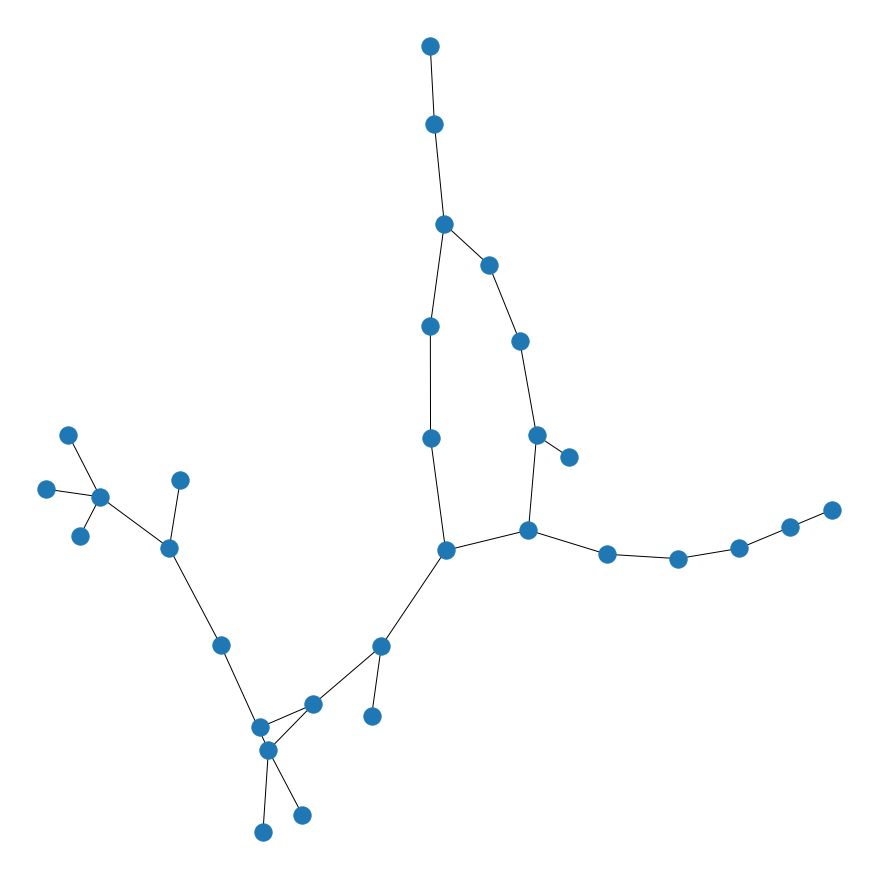

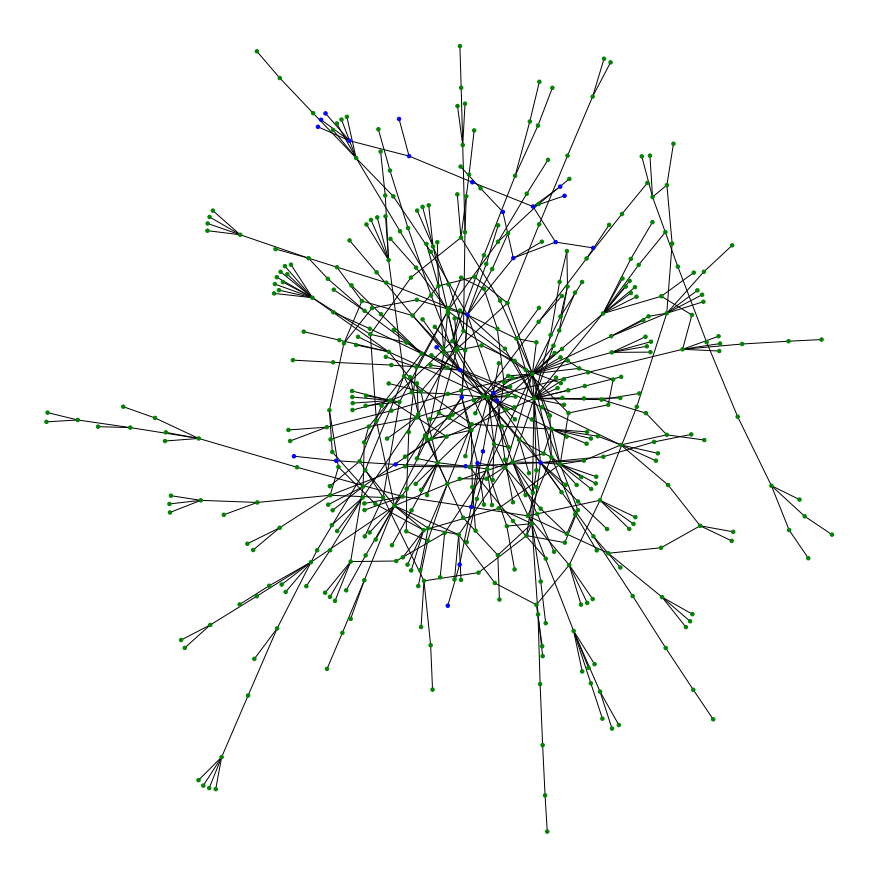

gonewildcurvy


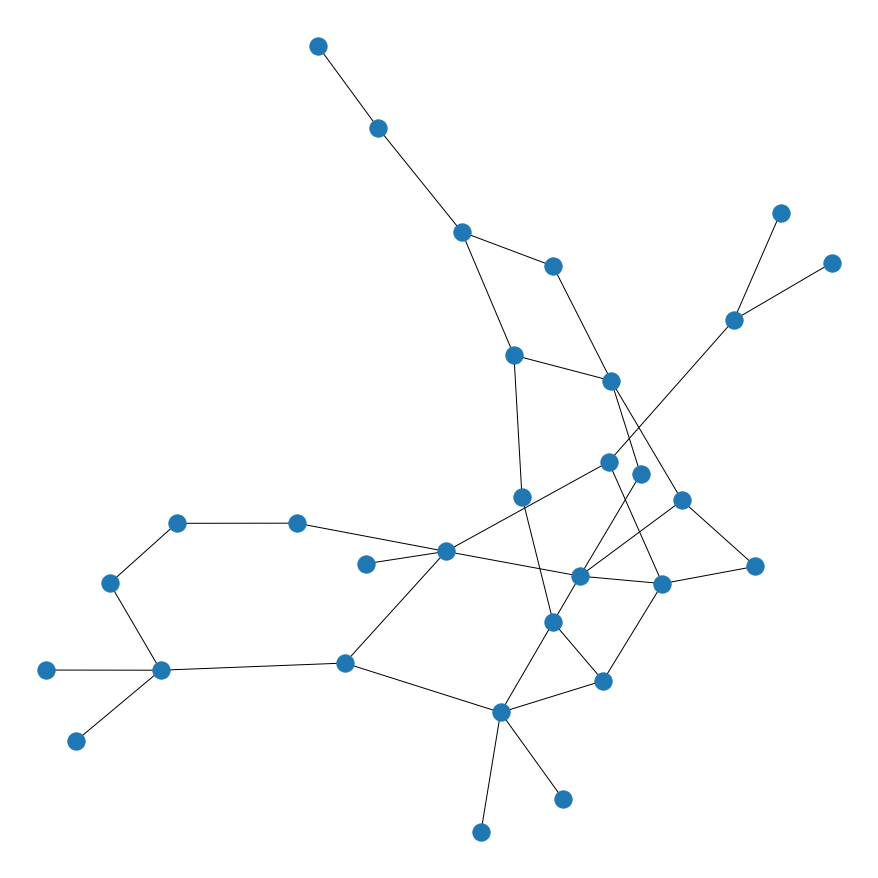

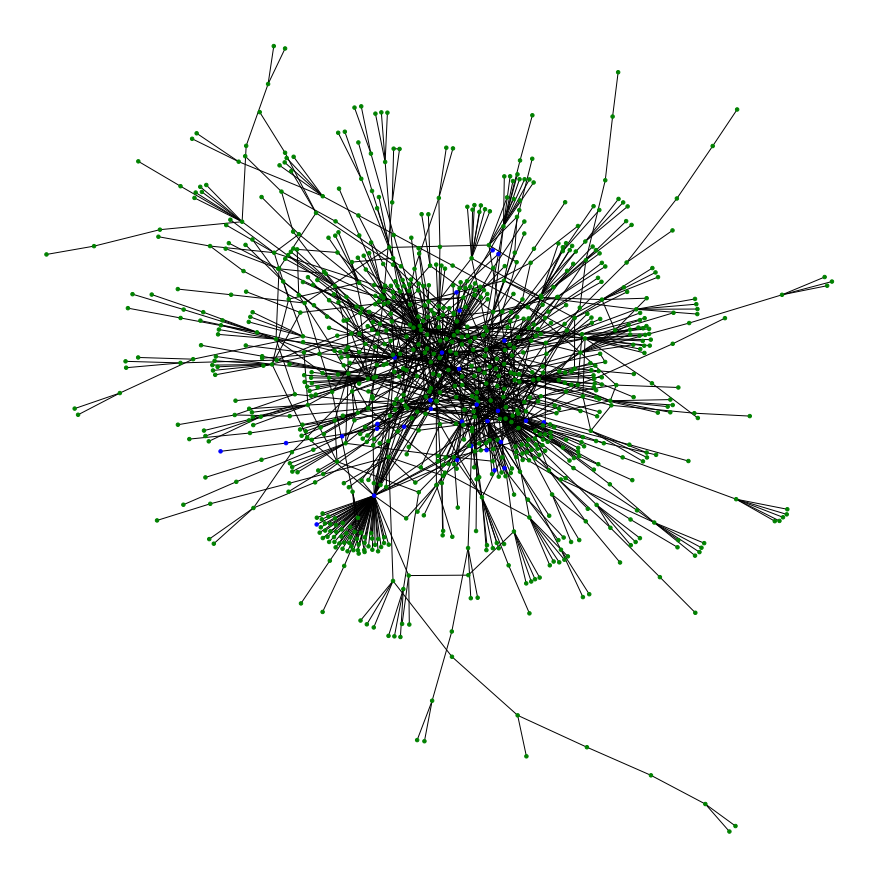

southpark


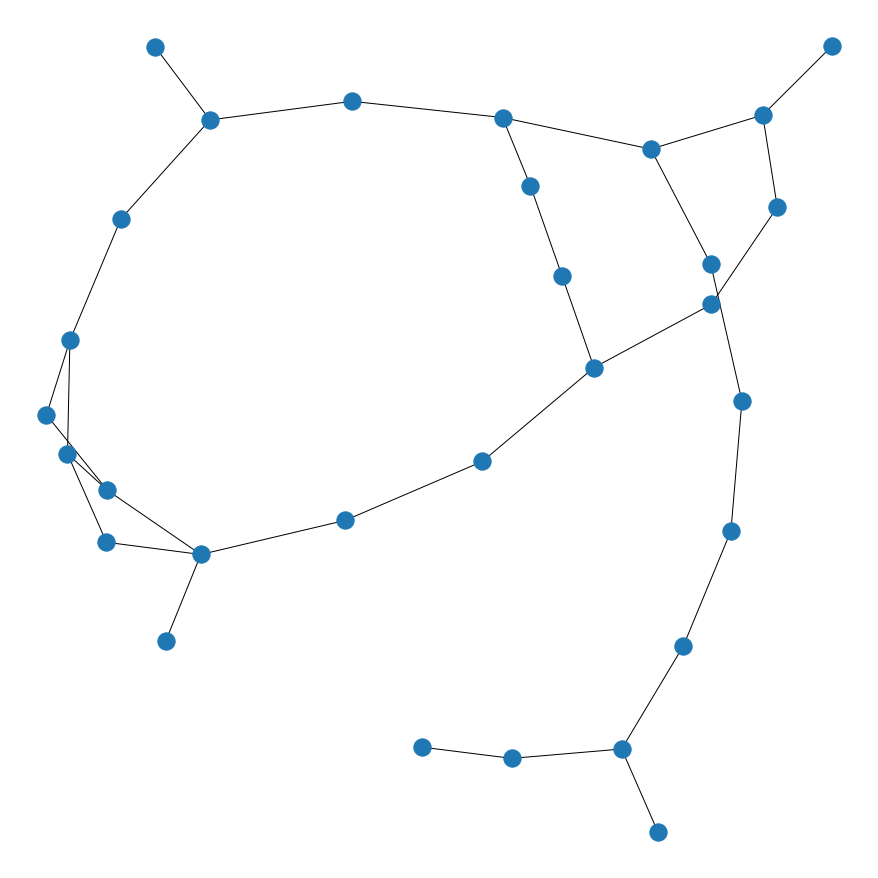

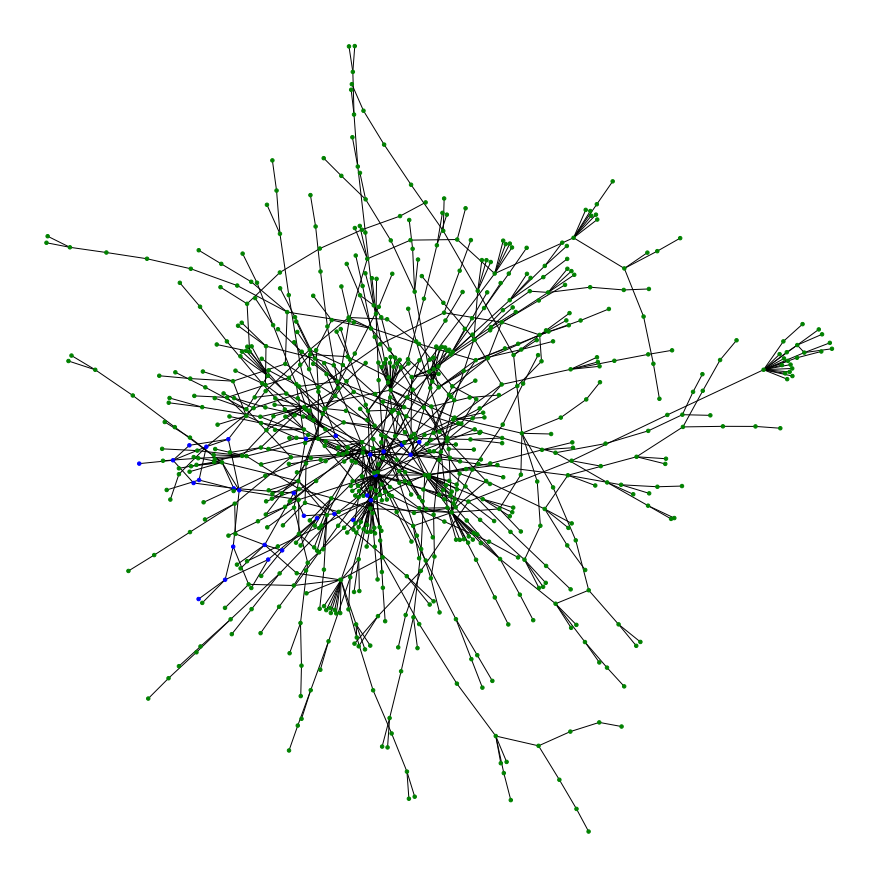

geology


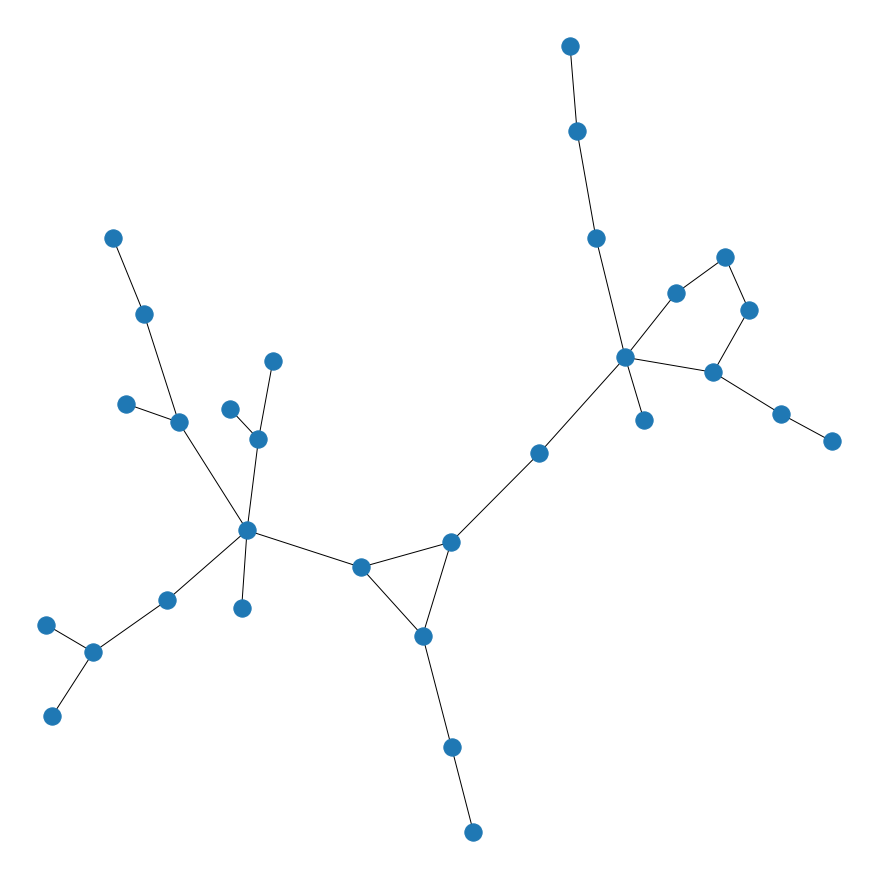

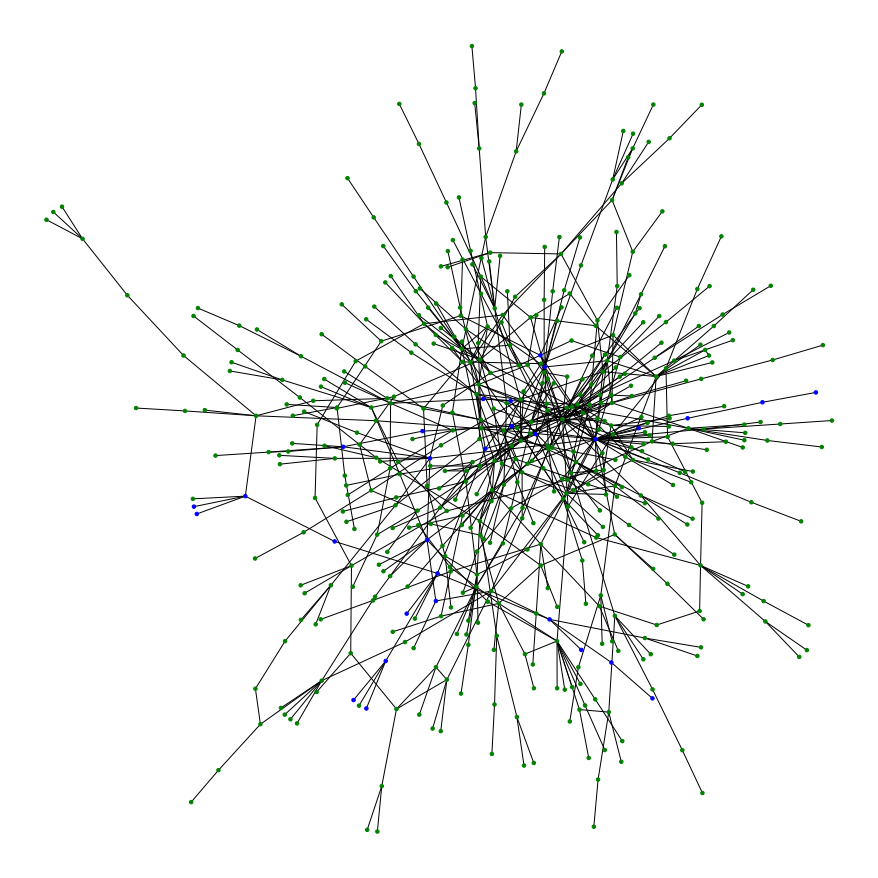

hardwareswap


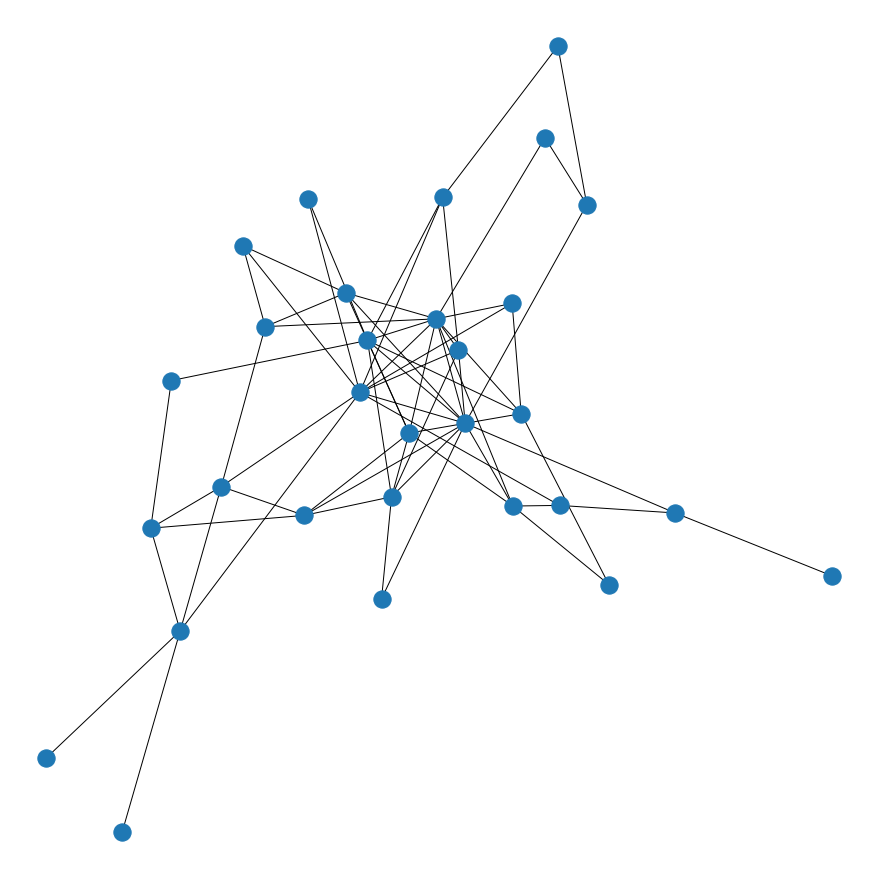

KeyboardInterrupt: 

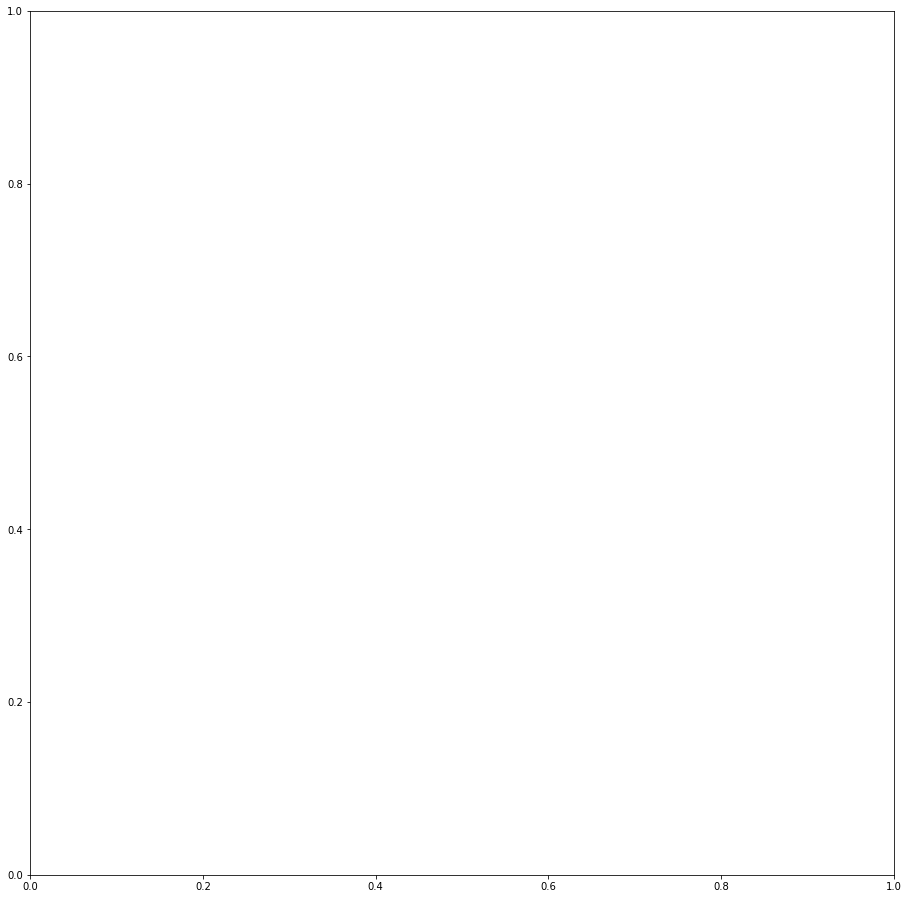

In [7]:
import networkx as nx 
import random


sampler = NonBackTrackingRandomWalkSampler(30)
for topic in topics_dict:
    i = random.choice(topics_dict[topic])
    sample = sampler.sample(graphs[i][1])
    sample_nodes = list(sample.nodes())
    print(topic)
    
    plt.figure(1,figsize=(12,12)) 
    nx.draw(sample)
    plt.show()
    
    color_map = []
    for node in graphs[i][1]:
        if node in sample_nodes:
            color_map.append('blue')
        else: 
            color_map.append('green')      
    plt.figure(2,figsize=(12,12)) 
    nx.draw(graphs[i][1], node_size=12, node_color=color_map)
    plt.show()
